In [1]:
from pathlib import Path
from acm.estimators.galaxy_clustering import DensitySplit
from acm.utils import setup_logging
from pypower import mpi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

setup_logging()

# read some random galaxy catalog
data_dir = '/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior2/c000_ph000/'
data_fn = Path(data_dir) / 'hod3177.npy'
data = np.load(data_fn, allow_pickle=True).item()
boxsize = 2000.0
x = data['x']
y = data['y']
z_rsd = data['z_rsd']
data_positions = np.c_[x, y, z_rsd]

In [2]:
import multiprocessing
nthreads = multiprocessing.cpu_count()
print(f'Running notebook with {nthreads} threads') 

Running notebook with 128 threads


### Calculate density quantiles

Note: when calling `set_density_contrast`, you can pass the argument `save_wisdom=True`, which will save a file on disk that will speed up FFT calculations next time you run the code with the same grid settings. This is highly recommended if you plan to run this on many mocks.

[000000.23]  04-14 13:09  DensitySplit                 INFO     Initializing DensitySplit.
[000000.23]  04-14 13:09  DensitySplit                 INFO     Box size: [2000. 2000. 2000.]
[000000.23]  04-14 13:09  DensitySplit                 INFO     Box center: [1000. 1000. 1000.]
[000000.23]  04-14 13:09  DensitySplit                 INFO     Box nmesh: [400 400 400]
[000016.65]  04-14 13:09  DensitySplit                 INFO     Set density contrast in 15.82 seconds.
[000016.65]  04-14 13:09  DensitySplit                 INFO     Generating random query points within the box.
[000020.02]  04-14 13:10  DensitySplit                 INFO     Quantiles calculated in 3.37 seconds.


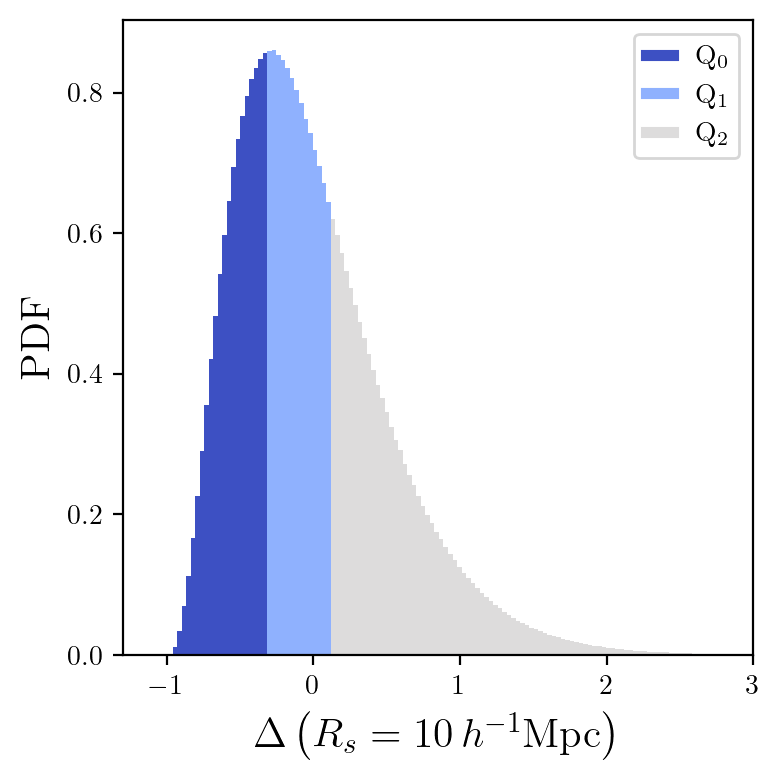

In [3]:
# calculate density splits
ds = DensitySplit(boxsize=boxsize, boxcenter=boxsize/2, cellsize=5.0)
ds.assign_data(positions=data_positions, wrap=True)
ds.set_density_contrast(smoothing_radius=10)
ds.set_quantiles(nquantiles=3, query_method='randoms')

ds.plot_quantiles()
plt.show()

### Calculate clustering in configuration space

[000021.33]  04-14 13:10  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000021.33]  04-14 13:10  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000021.34]  04-14 13:10  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000028.73]  04-14 13:10  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000028.74]  04-14 13:10  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 7.40 s.
[000028.74]  04-14 13:10  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000028.74]  04-14 13:10  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000028.74]  04-14 13:10  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000035.22]  04-14 13:10  TwoPointCorrelationFunction  INFO     Using precomputed two-point counts R1R2.
[000035

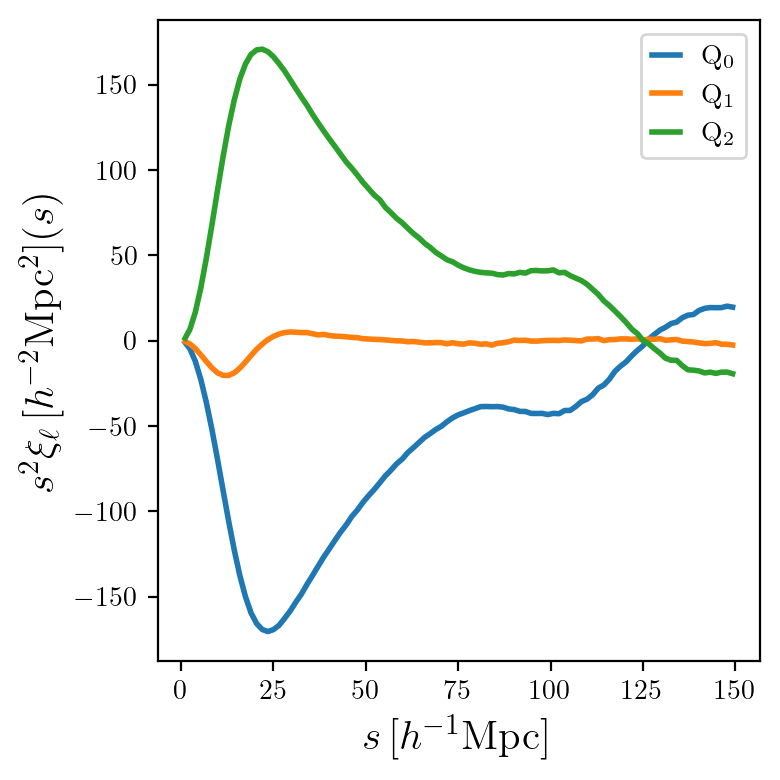

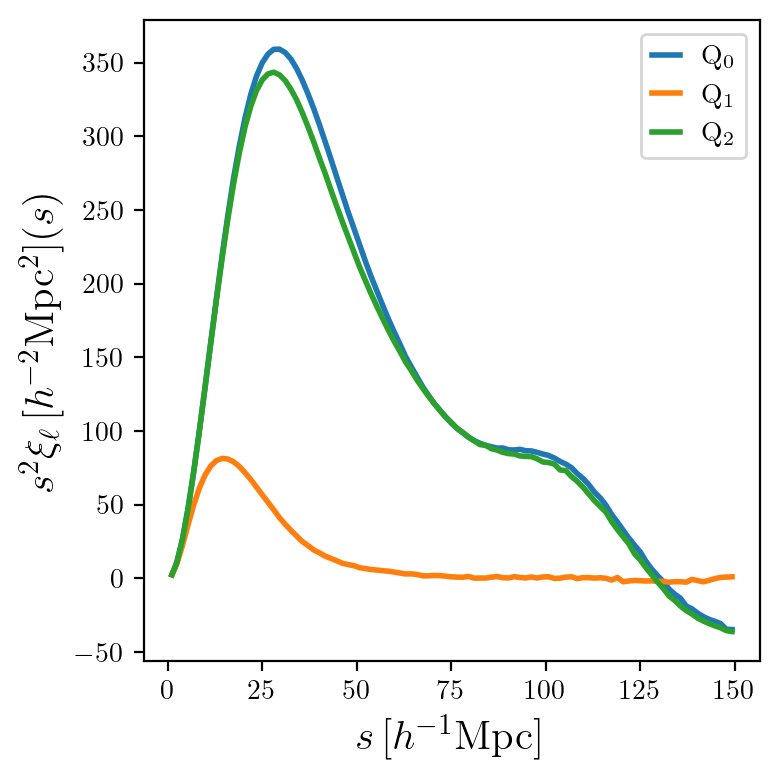

In [4]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
ds.quantile_data_correlation(data_positions, edges=(sedges, muedges), los='z', nthreads=nthreads)
ds.quantile_correlation(edges=(sedges, muedges), los='z', nthreads=nthreads)
ds.plot_quantile_data_correlation(ell=0)
ds.plot_quantile_correlation(ell=0)
plt.show()

### Calculate clustering in Fourier space

[000064.03]  04-14 13:10  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[2000. 2000. 2000.], boxcenter=[1000.00030518  999.99993896  999.9999357 ], dtype=float64).
[000064.14]  04-14 13:10  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 6662629.
[000065.96]  04-14 13:10  CatalogMesh                  INFO     Painted 4194304 out of 6662629 objects to mesh.
[000065.96]  04-14 13:10  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 6662629.
[000067.04]  04-14 13:10  CatalogMesh                  INFO     Painted 6662629 out of 6662629 objects to mesh.
[000067.04]  04-14 13:10  CatalogMesh                  INFO     Running interlacing at order 2.
[000067.36]  04-14 13:10  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 6662629.
[000069.16]  04-14 13:10  CatalogMesh                  INFO     Painted 4194304 out of 6662629 objects to mesh.
[000069.16]  04-14 13:10  CatalogMesh                  INFO   

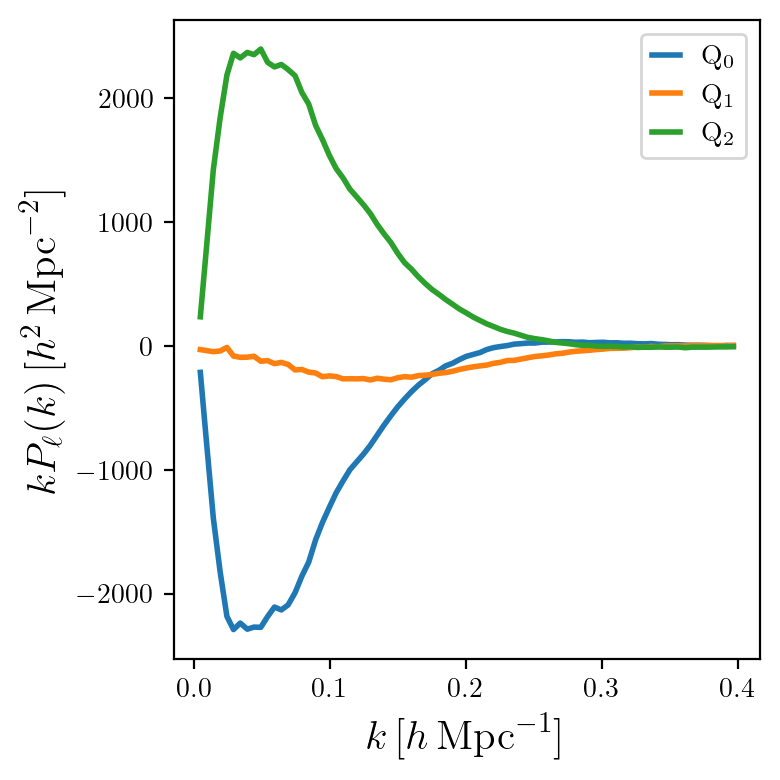

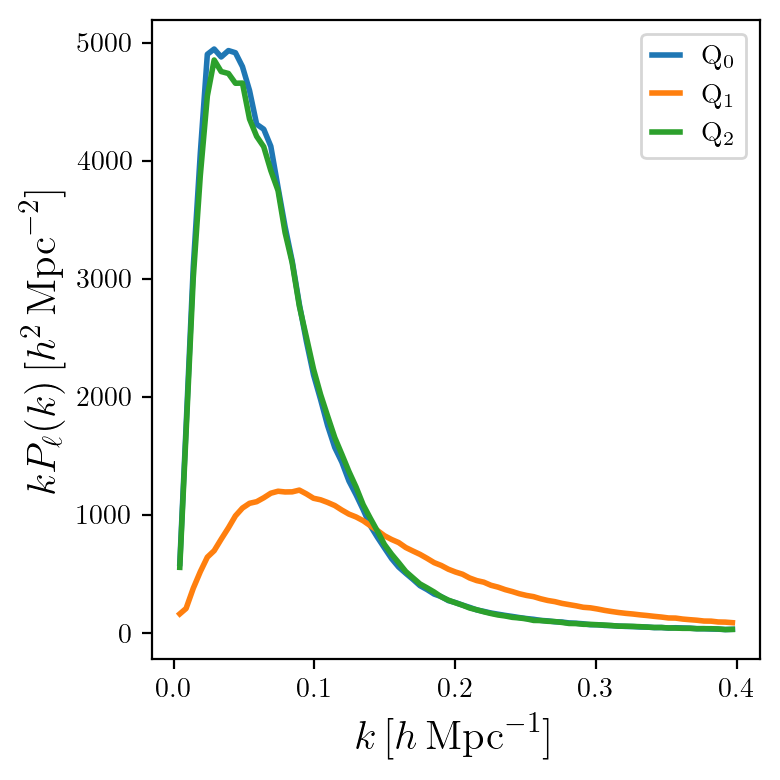

In [5]:
edges = np.linspace(0.001, 0.5, 100)
ds.quantile_data_power(data_positions, edges=edges, los='z', nmesh=256, )
ds.quantile_power(edges=edges, los='z', nmesh=256)
ds.plot_quantile_data_power(ell=0)
ds.plot_quantile_power(ell=0)
plt.show()

### Working with survey data

In [6]:
import fitsio
from cosmoprimo.fiducial import DESI
from pyrecon.utils import sky_to_cartesian


def read_desi(filename, distance, zmin=0.45, zmax=0.6):
    """Read CMASS LSS catalogues."""
    data = fitsio.read(filename)
    mask = (data['Z'] > zmin) & (data['Z'] < zmax)
    ra = data[mask]['RA']
    dec = data[mask]['DEC']
    redshift = data[mask]['Z']
    weights = data[mask]['WEIGHT']
    dist = distance(redshift)
    positions = sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    return positions, weights

setup_logging()
cosmo = DESI()
distance = cosmo.comoving_radial_distance

version = 'v1.2/blinded'
tracer = 'LRG'
zmin, zmax = 0.4, 0.6
region = 'NGC'
nrandoms = 5

# read data
data_dir = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{version}'
data_fn = Path(data_dir) / f'{tracer}_{region}_clustering.dat.fits'
data_positions, data_weights = read_desi(distance=distance, filename=data_fn, zmin=zmin, zmax=zmax)

# read randoms
randoms_positions = []
randoms_weights = []
for i in range(nrandoms):
    randoms_dir = Path('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.1/blinded/')
    randoms_fn = randoms_dir / f'{tracer}_{region}_{i}_clustering.ran.fits'
    randoms_positions_i, randoms_weights_i = read_desi(distance=distance, filename=randoms_fn,
                                                       zmin=zmin, zmax=zmax)
    randoms_positions.append(randoms_positions_i)
    randoms_weights.append(randoms_weights_i)
randoms_positions = np.concatenate(randoms_positions)
randoms_weights = np.concatenate(randoms_weights)

[000130.53]  04-14 13:11  jax._src.xla_bridge          INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
[000130.54]  04-14 13:11  jax._src.xla_bridge          INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[000016.71]  04-14 13:12  DensitySplit                 INFO     Initializing DensitySplit.
[000016.74]  04-14 13:12  DensitySplit                 INFO     Box size: [2740. 4235. 2660.]
[000016.74]  04-14 13:12  DensitySplit                 INFO     Box center: [-621.63848301  -84.969653    618.97756546]
[000016.74]  04-14 13:12  DensitySplit                 INFO     Box nmesh: [548 847 532]
[000054.05]  04-14 13:12  DensitySplit                 INFO     Set density contrast in 36.44 seconds.
[000054.44]  04-14 13:12  DensitySplit                 INFO     Quantiles calculated in 0.27 seconds.


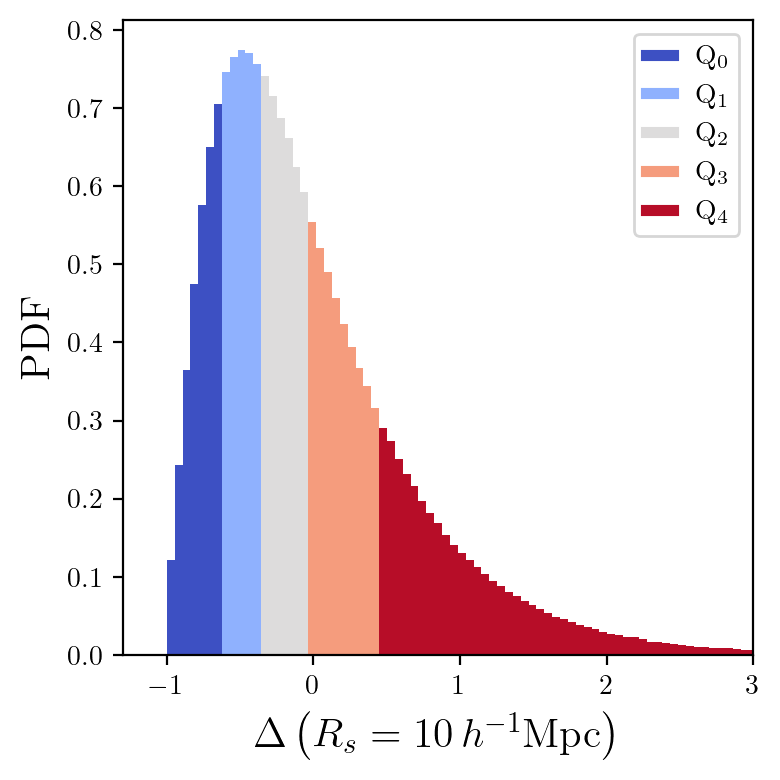

In [7]:
ds = DensitySplit(positions=randoms_positions, cellsize=5.0)
ds.assign_data(positions=data_positions, weights=data_weights)
ds.assign_randoms(positions=randoms_positions, weights=randoms_weights)
ds.set_density_contrast(smoothing_radius=10)

# note: when working with a non-uniform geometry, we need to explicitly
# define the query positions at which we want to sample the density field
nquery = 5 * len(data_positions)
idx = np.random.choice(len(randoms_positions), size=nquery)
query_positions = randoms_positions[idx]
ds.set_quantiles(nquantiles=5,  query_positions=query_positions)

ds.plot_quantiles()
plt.show()

[000055.30]  04-14 13:12  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000055.30]  04-14 13:12  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000055.30]  04-14 13:12  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000055.74]  04-14 13:12  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000061.12]  04-14 13:12  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000067.78]  04-14 13:12  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000200.97]  04-14 13:15  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 145.67 s.
[000200.97]  04-14 13:15  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000200.97]  04-14 13:15  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000200.97]  04-14

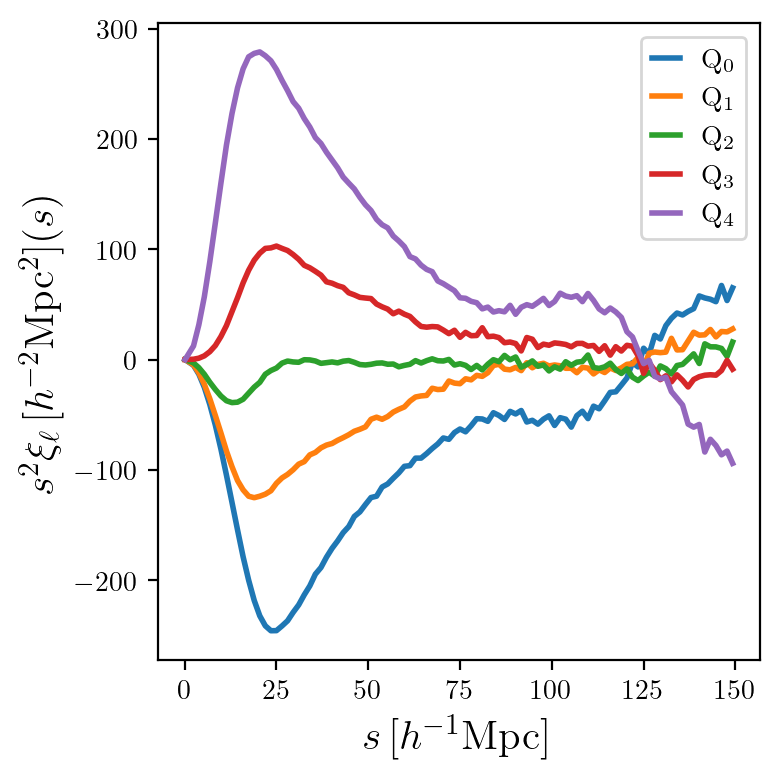

In [8]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
ds.quantile_data_correlation(data_positions=data_positions, randoms_positions=randoms_positions,
                             data_weights=data_weights, randoms_weights=randoms_weights,
                             edges=(sedges, muedges), los='midpoint', nthreads=nthreads)

ds.plot_quantile_data_correlation(ell=0)
plt.show()